# Fake News Clustering & Predictions

The purpose of this project is to test whether clustering algorithms, such as K-Means, DBSCAN, and others can effectively capture (and thus help predict) fake news from real news. The original dataset used was found on Kaggle at: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?select=True.csv

As the original datasets were seperated on the basis of ground truth, with one being the fake news and the other being real news, I decided to join them together. In doing so I created one `label` column designating ground truth and then pretended it was not there during the analysis; as well as saved it away and removed it from the dataframe in the short-term. This was done to simulate obtaining a new batch of news articles yet to be examined, and to undergo clustering analysis with the expectation of trying to capture the fake - real dichotomy.

The first part of this notebook is the imports and cleaning of the data, which took up most of my time throughout this project. 

## Imports:

In [1]:
## Imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# import plotly.express as px Didn't end up using

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import (
    MiniBatchKMeans,
    KMeans,
    DBSCAN,
    SpectralClustering,
    AgglomerativeClustering,
)
from scipy.cluster.hierarchy import dendrogram, linkage

# from sklearn.linear_model import LogisticRegression Didn't end up doing classification too -- TODO After Turn-in
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import (
    PCA,
    TruncatedSVD,
)  # Both are eigenvector decomposition algo's
from sklearn.manifold import TSNE  # TSNE

import umap  # Not in sklearn

# !pip install umap --> if not already installed

from wordcloud import WordCloud, STOPWORDS
from gensim.parsing.preprocessing import (
    preprocess_string,
    strip_tags,
    strip_punctuation,
    strip_multiple_whitespaces,
    strip_numeric,
    remove_stopwords,
    strip_short,
)  # Preprocesssing
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Word2Vec  # Word2vec

import string  # python library
import re  # regex library
from collections import defaultdict

import time

%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Data Preprocessing:

In [2]:
true = pd.read_csv("...Kaggle/True.csv")
fake = pd.read_csv("...Kaggle/Fake.csv")

<IPython.core.display.Javascript object>

In [3]:
# Need to remove (Reuters) tags and @realDonaldTrump:
cleansed_data = []
for data in true.text:
    if "@realDonaldTrump : - " in data:
        cleansed_data.append(data.split("@realDonaldTrump : - ")[1])
    elif "(Reuters) -" in data:
        cleansed_data.append(data.split("(Reuters) - ")[1])
    else:
        cleansed_data.append(data)

true["text"] = cleansed_data

<IPython.core.display.Javascript object>

In [4]:
fake["words"] = fake["title"] + " " + fake["text"]
true["words"] = true["title"] + " " + true["text"]

# Adding fake and true label
fake["label"] = 0
true["label"] = 1

# We can merge both together since we now have labels
df = pd.concat([fake, true])

# Randomize the rows so its all mixed up
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# df.head(10)

<IPython.core.display.Javascript object>

In [5]:
df["words"][8]

'North Korea shows no sign it is serious about talking: U.S. official The State Department said Wednesday that the United States would be open to talking to North Korea  when the time is right  but that it could not happen now because Pyongyang has shown no sign of a willingness to halt its missile and nuclear testing. Despite U.S. Secretary of State Rex Tillerson s offer on Tuesday to start talks with North Korea without pre-conditions, State Department spokeswoman Heather Nauert said there would first have to be a  period of calm  in which Pyongyang suspends  testing before any negotiations could begin. Tillerson, in a speech to a Washington think tank on Tuesday, did not explicitly establish such a freeze as a requirement that North Korea must meet ahead of talks. Nauert, speaking at the State Department s daily briefing, insisted that Tillerson was not establishing new policy in his speech, even though he appeared to back away from a key U.S. demand that Pyongyang must first accept

<IPython.core.display.Javascript object>

In [6]:
df.isna().mean()  # no missing values!

title      0.0
text       0.0
subject    0.0
date       0.0
words      0.0
label      0.0
dtype: float64

<IPython.core.display.Javascript object>

In [7]:
## Storing away `is_real` labels for future supervised learning:
df_copy = df.copy()

labels = df["label"]

# Downsampling for computer run times -- faced many issues running on
# whole df at once
df_subset = df.sample(n=1000, replace=False, random_state=42)

# df = df.drop(columns=["Label"])
df_subset.head()

,title,text,subject,date,words,label
22216,It’s Really Happening: Trump Adviser Lays Out...,"Well, that didn t take long. In the short time...",News,"November 16, 2016",It’s Really Happening: Trump Adviser Lays Out...,0
27917,Republican attempt to deflect Trump-Russia pro...,Republican lawmaker Devin Nunes’ investigation...,politicsNews,"September 11, 2017",Republican attempt to deflect Trump-Russia pro...,1
25007,Trump says churches should get FEMA funds for ...,President Donald Trump said on Friday that chu...,politicsNews,"September 9, 2017",Trump says churches should get FEMA funds for ...,1
1377,Trump Loves To Say The New York Times Is ‘Fai...,Print journalism and longstanding papers have ...,News,"August 7, 2017",Trump Loves To Say The New York Times Is ‘Fai...,0
32476,House Speaker Ryan briefed Trump on healthcare...,President Donald Trump was being briefed on Fr...,politicsNews,"March 24, 2017",House Speaker Ryan briefed Trump on healthcare...,1


<IPython.core.display.Javascript object>

In [8]:
# Fairly balanced classes in the subset as well
# df_subset['label'].value_counts()

# Going to save these away and then remove later
sub_labels = df_subset["label"]

<IPython.core.display.Javascript object>

In [9]:
# Here we preprocess the sentences
def remove_URL(s):
    regex = re.compile(r"https?://\S+|www\.\S+|bit\.ly\S+")
    return regex.sub(r"", s)


# Preprocessing functions to remove lowercase, links, whitespace, tags, numbers, punctuation, strip words
CUSTOM_FILTERS = [
    lambda x: x.lower(),
    strip_tags,
    remove_URL,
    strip_punctuation,
    strip_multiple_whitespaces,
    strip_numeric,
    remove_stopwords,
    strip_short,
]

# Here we store the processed sentences and their label
processed_data = []
processed_labels = []

for index, row in df_subset.iterrows():
    words_broken_up = preprocess_string(row["words"], CUSTOM_FILTERS)
    # This eliminates any fields that may be blank after preprocessing
    if len(words_broken_up) > 0:
        processed_data.append(words_broken_up)
        processed_labels.append(row["label"])

<IPython.core.display.Javascript object>

In [10]:
# Word2Vec model trained from process up above
model = Word2Vec(processed_data, min_count=1)

<IPython.core.display.Javascript object>

In [11]:
# Examining most similar words to nation:
model.wv.most_similar("nation")

# Seems to be working!

[('peace', 0.9999115467071533),
 ('economic', 0.9999050498008728),
 ('cities', 0.9998969435691833),
 ('agreement', 0.9998799562454224),
 ('yemen', 0.9998762607574463),
 ('israel', 0.9998695850372314),
 ('groups', 0.9998537302017212),
 ('ultimately', 0.9998530149459839),
 ('remain', 0.9998517036437988),
 ('pakistan', 0.999847948551178)]

<IPython.core.display.Javascript object>

In [12]:
# Vectorizing: --> vector of sentence = avg of all word vectors in sentence
def ReturnVector(x):
    try:
        return model[x]
    except:
        return np.zeros(100)


def Sentence_Vector(sentence):
    word_vectors = list(map(lambda x: ReturnVector(x), sentence))
    return np.average(word_vectors, axis=0).tolist()


X = []
for data_x in processed_data:
    X.append(Sentence_Vector(data_x))

<ipython-input-12-7b4bf89a173c>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return model[x]


<IPython.core.display.Javascript object>

In [13]:
# Convert to array for ease of analysis
X_array = np.array(X)
X_array.shape

(1000, 100)

<IPython.core.display.Javascript object>

In [14]:
# Keeping these out of the dataframe to keep unsupervised
df = df.drop(columns=["label"])
df_subset = df_subset.drop(columns=["label"])

<IPython.core.display.Javascript object>

## Dimension Reduction

In [15]:
# Plotting with UMAP
time_start = time.time()
embedding = umap.UMAP(n_components=2).fit_transform(X_array)

print("UMAP done! Time elapsed: {} seconds".format(time.time() - time_start))

UMAP done! Time elapsed: 9.944463729858398 seconds


<IPython.core.display.Javascript object>

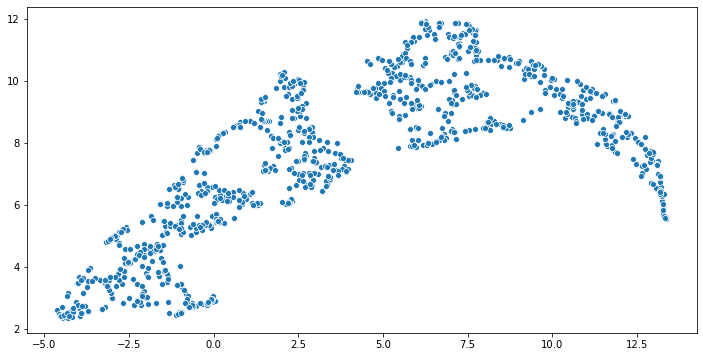

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1])

Interesting how `UMAP` has distributed the data points.

In [17]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1)
components = tsne.fit_transform(X_array)

print("t-SNE done! Time elapsed: {} seconds".format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.023s...
[t-SNE] Computed neighbors for 1000 samples in 0.191s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.060433
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.025635
[t-SNE] KL divergence after 1000 iterations: 0.602071
t-SNE done! Time elapsed: 6.89367938041687 seconds


<IPython.core.display.Javascript object>

Text(0, 0.5, 't-SNE Component 2')

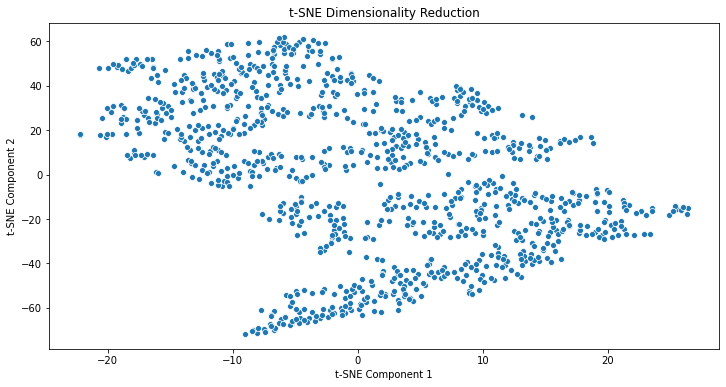

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=components[:, 0],
    y=components[:, 1],
)

# plt.legend()
plt.title("t-SNE Dimensionality Reduction")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

Not doing too bad of a job here either.

In [19]:
time_start = time.time()

# Plotting using SVD:
svd_model = TruncatedSVD(
    n_components=2,  # number of dimensions
    algorithm="randomized",
    n_iter=100,
    random_state=42,
)

svd = svd_model.fit_transform(X)
print("SVD done! Time elapsed: {} seconds".format(time.time() - time_start))

SVD done! Time elapsed: 0.14167118072509766 seconds


<IPython.core.display.Javascript object>

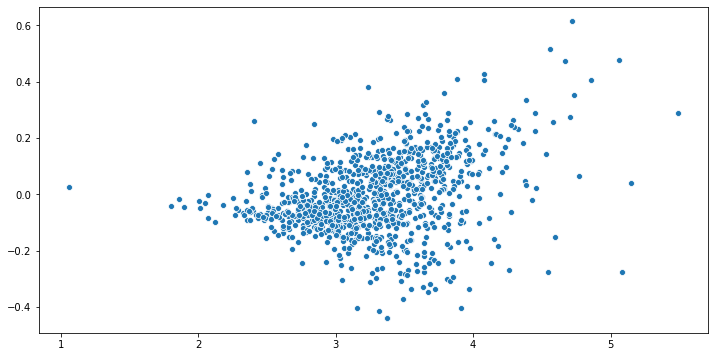

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=svd[:, 0],
    y=svd[:, 1],
)

We might be able to discern real - fake news from this dimension reduction techinque, however it might not be capturing the real - fake dichotomy.

In [21]:
# Trying PCA, now that tf-idf has been converted to dense matrix:
pca = PCA(2)
pca = pca.fit_transform(X_array)

<IPython.core.display.Javascript object>

Text(0, 0.5, 'PCA Component 2')

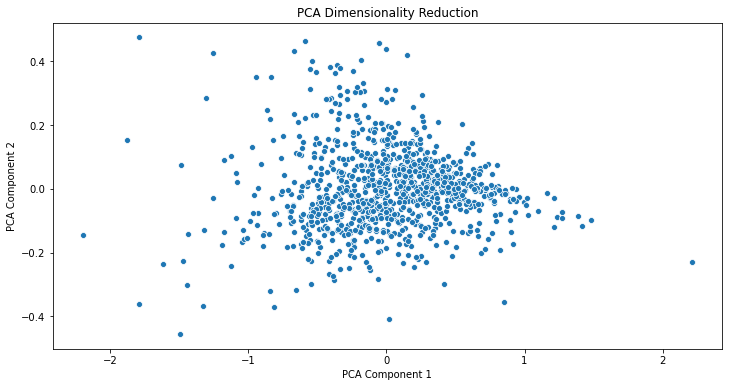

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=pca[:, 0], y=pca[:, 1])
plt.title("PCA Dimensionality Reduction")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

This has done a similar transformation as the SVD (undoubtably because they both use eigenvector decompositions).

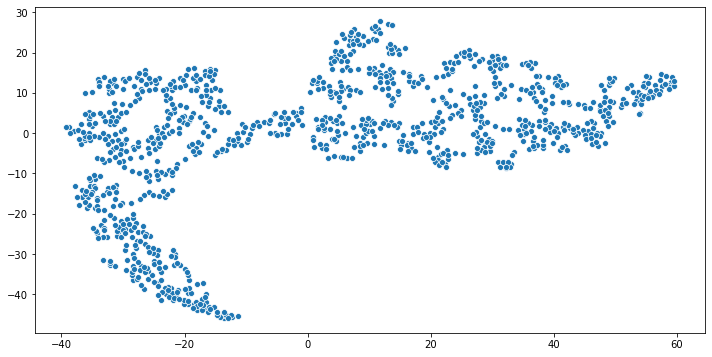

<IPython.core.display.Javascript object>

In [23]:
## Trying a t-SNE transform on the PCA:
t_sne = TSNE(2)
t_sne = t_sne.fit_transform(pca)

plt.figure(figsize=(12, 6))
sns.scatterplot(x=t_sne[:, 0], y=t_sne[:, 1])

This dimension reduction seems to capture the various structures of clusters in our data!

## EDA

Text(0.5, 0, 'Subject')

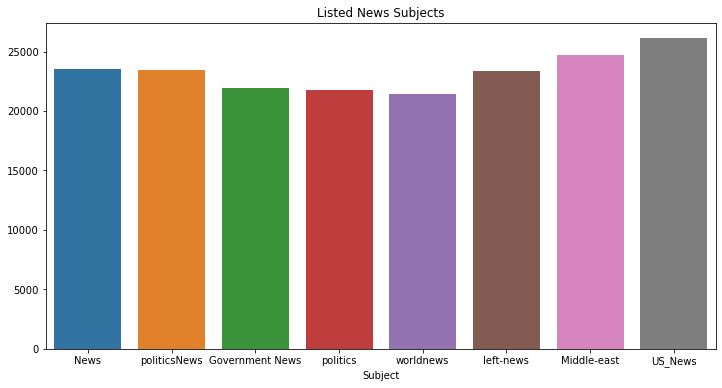

<IPython.core.display.Javascript object>

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(x="subject", y=df_subset.index, data=df_subset, ci=None)
plt.title("Listed News Subjects")
# plt.yticks([])
plt.xlabel("Subject")
# plt.legend()

In [25]:
lengths = pd.Series([len(x) for x in df_subset.words])
print("Statistical Summary of Article Lengths")
print(lengths.describe())

Statistical Summary of Article Lengths
count     1000.000000
mean      2607.448000
std       2463.467801
min         66.000000
25%       1299.750000
50%       2266.500000
75%       3269.500000
max      47048.000000
dtype: float64


<IPython.core.display.Javascript object>

Text(0.5, 0, 'Number of Characters')

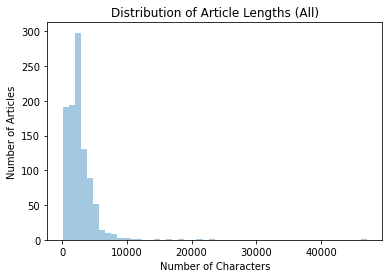

<IPython.core.display.Javascript object>

In [26]:
sns.distplot(lengths, kde=False)
plt.title("Distribution of Article Lengths (All)")
# sns.distplot(lengths[lengths < 10000], kde=False)
# plt.title("Distribution of Articles Lengths < 10,000 Characters")
plt.ylabel("Number of Articles")
plt.xlabel("Number of Characters")

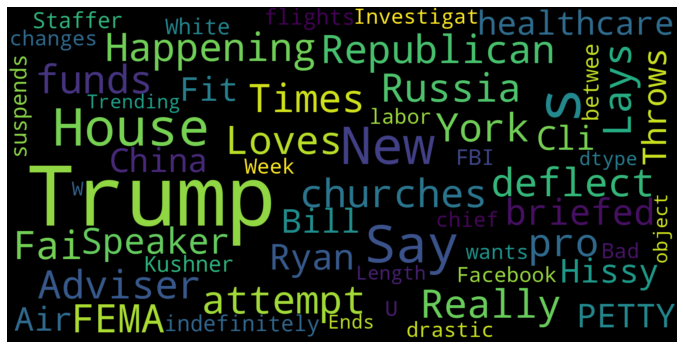

<IPython.core.display.Javascript object>

In [27]:
# All News Worldcloud
# data1 = df_subset[df_subset["real"] == 1]
neg = df_subset["words"]
neg_string = []
for t in neg:
    neg_string.append(t)
neg_string = pd.Series(neg_string).map(str)
neg_string = str(neg_string)


wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Clustering with K-Means

Text(0.5, 1.0, 'Elbow Method For Optimal k')

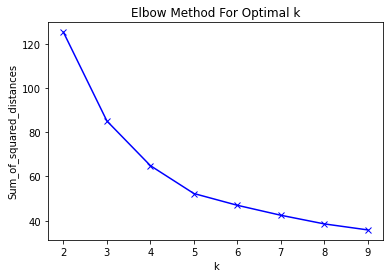

<IPython.core.display.Javascript object>

In [28]:
# Trying elbow method for K-Means:
sum_squared_distances = []
K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, max_iter=300, n_init=10, random_state=42)
    km.fit_predict(X)
    sum_squared_distances.append(km.inertia_)

plt.plot(K, sum_squared_distances, "bx-")
plt.xlabel("k")
plt.ylabel("Sum_of_squared_distances")
plt.title("Elbow Method For Optimal k")

In [29]:
range_n_clusters = (2, 3, 4, 5, 6, 7, 8)

<IPython.core.display.Javascript object>

In [30]:
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is:",
        round(silhouette_avg, 4),
    )

For n_clusters = 2 The average silhouette_score is: 0.45
For n_clusters = 3 The average silhouette_score is: 0.3875
For n_clusters = 4 The average silhouette_score is: 0.3744
For n_clusters = 5 The average silhouette_score is: 0.3517
For n_clusters = 6 The average silhouette_score is: 0.3098
For n_clusters = 7 The average silhouette_score is: 0.2852
For n_clusters = 8 The average silhouette_score is: 0.2916


<IPython.core.display.Javascript object>

In [31]:
# Trying Out 8 Clusters (best Silhouette score from above)
true_k = 2
kmeans = KMeans(n_clusters=true_k, random_state=10, verbose=1)
kms = kmeans.fit_predict(X_array)
labels = kms.labels_

# centers = model.cluster_centers_.argsort()[:, ::-1]
# terms = vec.get_feature_names()

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 125.50489145876438
start iteration
done sorting
end inner loop
Iteration 1, inertia 125.37407619876991
start iteration
done sorting
end inner loop
Iteration 2, inertia 125.3371522148887
start iteration
done sorting
end inner loop
Iteration 3, inertia 125.33517388915537
start iteration
done sorting
end inner loop
Iteration 4, inertia 125.3335452801563
start iteration
done sorting
end inner loop
Iteration 5, inertia 125.33224974562717
start iteration
done sorting
end inner loop
Iteration 6, inertia 125.33071141394556
start iteration
done sorting
end inner loop
Iteration 7, inertia 125.33071141394556
center shift 0.000000e+00 within tolerance 2.648296e-07
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 126.86558903871723
start iteration
done sorting
end inner loop
Iteration 1, inertia 125.5915943474155
start iteration
done sorting
end inner loop
Iteration 2, in

AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

<IPython.core.display.Javascript object>

In [32]:
# Storing cluster labels into subset dataframe
df_subset["kms_prediction"] = labels
# df_subset.head()

<IPython.core.display.Javascript object>

In [33]:
# Creating test DF of Label Prediction on Article Labels:
test_df = {"words": processed_data, "labels": processed_labels, "KMeans": kms}
test_df = pd.DataFrame(test_df)

# test_df.head()

<IPython.core.display.Javascript object>

Text(0, 0.5, 't-SNE Component 2')

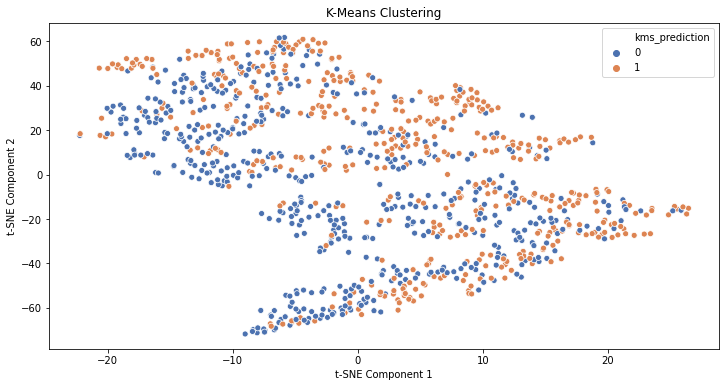

<IPython.core.display.Javascript object>

In [34]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=components[:, 0],
    y=components[:, 1],
    hue=df_subset["kms_prediction"],
    palette="deep",
)

plt.title("K-Means Clustering")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

Plotted K-Means with `k = 2` as the best Silhouette Score above was obtained with that `n_clusters`. Clearly when using K-Means, we see delineations on the fake - real basis (*hopefull*). We can see some clusters of articles which may be similar by topic, etc. that *hopefully* will also align with fake or real news articles. Interesting how the `Silhouette Score` was still only 0.45, clearly showing how similar many of these articles are, regardless of category.

## Clustering with DBSCAN & Spectral

In [35]:
dbscan = DBSCAN(eps=0.5, min_samples=10, n_jobs=-1)
dbscan.fit_predict(X_array)

db_labels = dbscan.labels_

<IPython.core.display.Javascript object>

In [36]:
df_subset["dbscan_labels"] = db_labels
# df_subset.head()
# test_df["dbscan_pred"] = db_labels

<IPython.core.display.Javascript object>

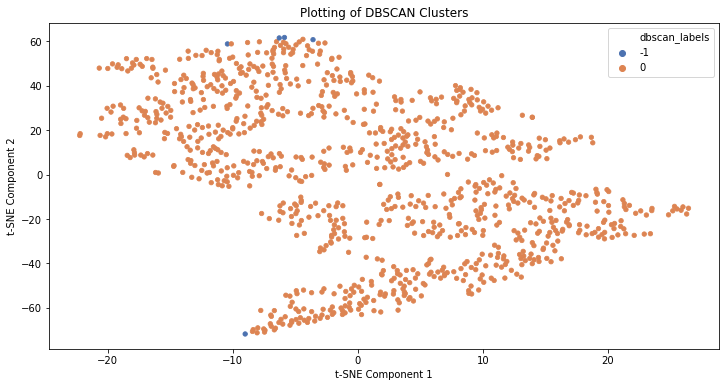

<IPython.core.display.Javascript object>

In [37]:
# Plotting with SVD
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=components[:, 0],
    y=components[:, 1],
    hue=df_subset["dbscan_labels"],
    s=20,
    palette="deep",
    edgecolor=None,
)

plt.ylabel("t-SNE Component 2")
plt.xlabel("t-SNE Component 1")
plt.title(
    "Plotting of DBSCAN Clusters",
)
plt.legend()

In [38]:
silhouette_score(X_array, db_labels)

0.6962521778997691

<IPython.core.display.Javascript object>

Here we see that DBSCAN has not clustered effectively, except when it can fit the `eps` and `min_samples` allows, when messing around with the parameters, the model shucked most of our articles into the `-1 cluster` which is our noise cluster.

In [39]:
clustering = SpectralClustering(
    n_clusters=2,
    assign_labels="discretize",
    affinity="rbf",
    random_state=42,
)

y_pred = clustering.fit_predict(X)
df_subset["spectral_labels"] = y_pred
test_df["spectral_pred"] = y_pred

<IPython.core.display.Javascript object>

In [40]:
silhouette_score(X_array, y_pred)

0.450737640299804

<IPython.core.display.Javascript object>

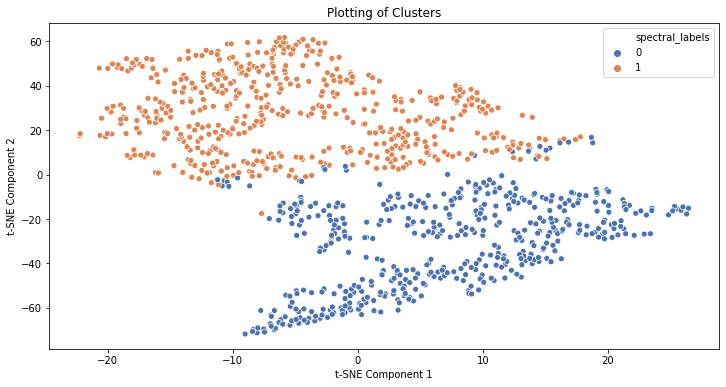

<IPython.core.display.Javascript object>

In [41]:
# Plotting with t-SNE
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=components[:, 0],
    y=components[:, 1],
    hue=df_subset["spectral_labels"],
    palette="deep",
    #     s=30,
    #     edgecolor=None,
)

plt.ylabel("t-SNE Component 2")
plt.xlabel("t-SNE Component 1")
plt.title(
    "Plotting of Clusters",
)
plt.legend()

Interesting to see how Spectral Clustering graphed our clusters in an almost identical manner to `K-Means` above. There are some decent looking clusters here, we shall see if they align best with our ground truth labels.

## Clustering with Hierarchical Clustering

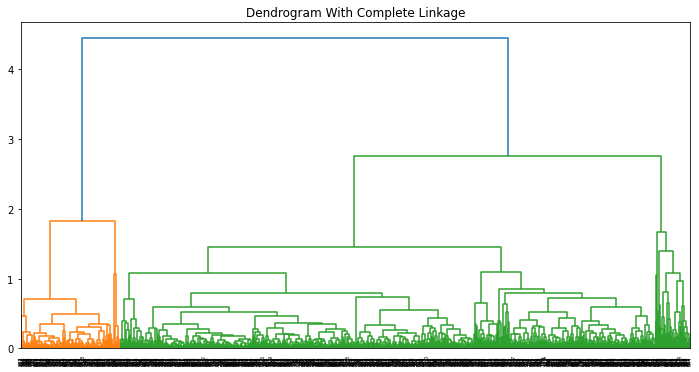

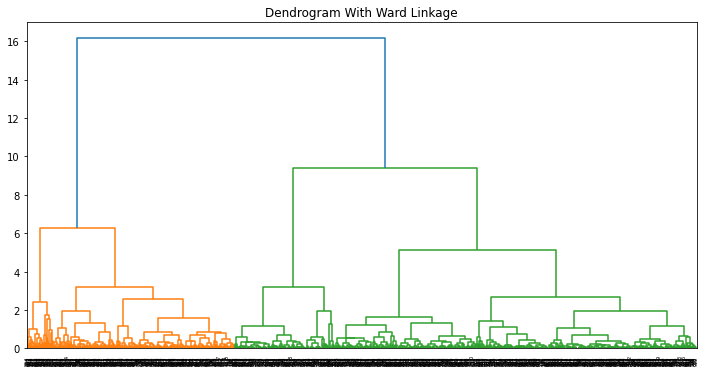

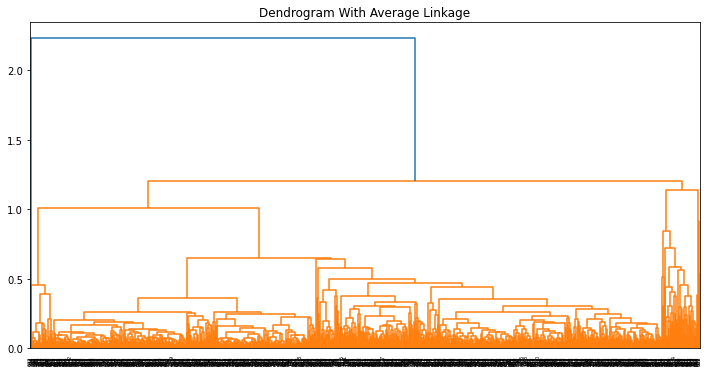

<IPython.core.display.Javascript object>

In [42]:
# Creating dendrograms
plt.figure(figsize=(12, 6))
plt.title("Dendrogram With Complete Linkage")
dendrogram(linkage(X, method="complete"))

plt.figure(figsize=(12, 6))
plt.title("Dendrogram With Ward Linkage")
dendrogram(linkage(X, method="ward"))

plt.figure(figsize=(12, 6))
plt.title("Dendrogram With Average Linkage")
avg = dendrogram(linkage(X, method="average"))

In [43]:
# Looks like Ward linkage might be the way to go...
# Generating Instance - Ward Linkage
clst = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="ward")
pred = clst.fit_predict(X_array)

# ARI & Silhouette Scores
# print(f"ARI Score for Ward Linkage is {metrics.adjusted_rand_score(X, pred)}")
print(
    "Silhouette score with Ward Linkage: {}".format(
        silhouette_score(X, pred, metric="euclidean")
    )
)

Silhouette score with Ward Linkage: 0.44487027449406386


<IPython.core.display.Javascript object>

In [44]:
# Storing cluster labels into dataframe
hier_labels = clst.labels_
df_subset["hier_labels"] = hier_labels
test_df["heirarchical_pred"] = hier_labels

<IPython.core.display.Javascript object>

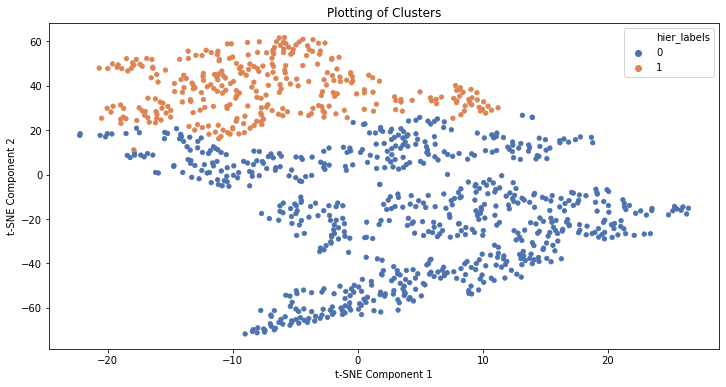

<IPython.core.display.Javascript object>

In [45]:
# Plotting with SVD
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=components[:, 0],
    y=components[:, 1],
    hue=df_subset["hier_labels"],
    palette="deep",
    s=20,
    #     alpha=0.5,
    edgecolor=None,
)

plt.ylabel("t-SNE Component 2")
plt.xlabel("t-SNE Component 1")
plt.title(
    "Plotting of Clusters",
)
plt.legend()

Hierarchical Clustering did not do as great of a job, weirdly enough, with `ward = linkage` the `silhouette_score` was around 0.2 lower than with average linkage and `manhattan` distance. But the latter option plotted these clusters worse.

## Assessing Clustering Effectiveness in Detecting Fake News Using Ground Truth

In the above sections covering K-Means, DBSCAN, Hierarchical Clustering and Spectral Clustering there were two commonalities among the clustering distributions:
    1. Silhouette Scores (throughout each clustering method) remained relatively low - closer to 0
        a. Silhouette scores close to zero indicate that points within the clusters are relatively close to the decision boundaries of nearby clusters.
    2. Dividing the data to two clusters (fake - real) generally created worse clusters (in terms of Silhouette score) as compared to 3+ clusters

For this next portion of the analysis, the `is_real` labels given from the data source will be imputed back in, to assess whether various clusters may have captured some of the interactions of fake/real news in our original data.

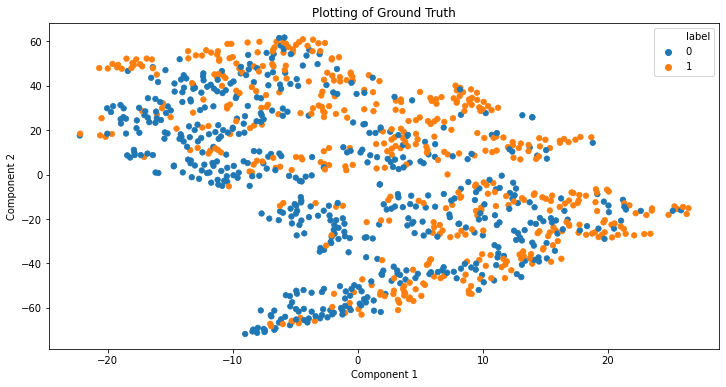

<IPython.core.display.Javascript object>

In [46]:
# Ground Truth Clustering
# Plotting with SVD
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=components[:, 0],
    y=components[:, 1],
    hue=sub_labels,
    s=30,
    edgecolor=None,
)

plt.ylabel("Component 2")
plt.xlabel("Component 1")
plt.title(
    "Plotting of Ground Truth",
)
plt.legend()
plt.show()

It should be noted - from the above plotting - that many articles have significant overlap. There is no clear line from which to delineate fake from real news. This speaks to the complexity and difficulty in determining trustworthiness of news articles.

In [47]:
df_subset["real"] = sub_labels

<IPython.core.display.Javascript object>

In [48]:
df_subset.head()

,title,text,subject,date,words,kms_prediction,dbscan_labels,spectral_labels,hier_labels,real
22216,It’s Really Happening: Trump Adviser Lays Out...,"Well, that didn t take long. In the short time...",News,"November 16, 2016",It’s Really Happening: Trump Adviser Lays Out...,0,0,1,0,0
27917,Republican attempt to deflect Trump-Russia pro...,Republican lawmaker Devin Nunes’ investigation...,politicsNews,"September 11, 2017",Republican attempt to deflect Trump-Russia pro...,1,0,1,1,1
25007,Trump says churches should get FEMA funds for ...,President Donald Trump said on Friday that chu...,politicsNews,"September 9, 2017",Trump says churches should get FEMA funds for ...,1,0,0,0,1
1377,Trump Loves To Say The New York Times Is ‘Fai...,Print journalism and longstanding papers have ...,News,"August 7, 2017",Trump Loves To Say The New York Times Is ‘Fai...,0,0,0,0,0
32476,House Speaker Ryan briefed Trump on healthcare...,President Donald Trump was being briefed on Fr...,politicsNews,"March 24, 2017",House Speaker Ryan briefed Trump on healthcare...,1,0,1,1,1


<IPython.core.display.Javascript object>

How Correct Where Each of The Models?

In [49]:
# K-Means Scorring
kms_correct = 0
kms_incorrect = 0

for index, row in df_subset.iterrows():
    if row["kms_prediction"] == row["real"]:
        kms_correct += 1
    else:
        kms_incorrect += 1

print(f"K-Means Correctly Clustered: {(kms_correct*100)/(kms_correct+kms_incorrect)}%!")

K-Means Correctly Clustered: 100.0%!


<IPython.core.display.Javascript object>

Going to skip DBSCAN as we know from it only generating one cluster it's accuracy will be the percentage breakdown of fake - real!

In [50]:
# Spectral Clustering Accuracy:
(
    df_subset["spectral_labels"].sum()
    / (df_subset["real"].sum() + df_subset["spectral_labels"].sum())
)

0.5246231155778894

<IPython.core.display.Javascript object>

In [51]:
# Spectral Clustering Accuracy:
(
    df_subset["hier_labels"].sum()
    / (df_subset["real"].sum() + df_subset["hier_labels"].sum())
)

0.3959131545338442

<IPython.core.display.Javascript object>

In [52]:
# # Spectral Scoring
# hier_correct = 0
# hier_incorrect = 0

# for index, row in df_subset.iterrows():
#     if row["hier_labels"] == row["real"]:
#         kms_correct += 1
#     else:
#         kms_incorrect += 1

# print(
#     f"Spectral Correctly Clustered: {(hier_correct*100)/(hier_correct+hier_incorrect)}%!"
# )

<IPython.core.display.Javascript object>

In [53]:
df_subset["real"].mean()

0.473

<IPython.core.display.Javascript object>

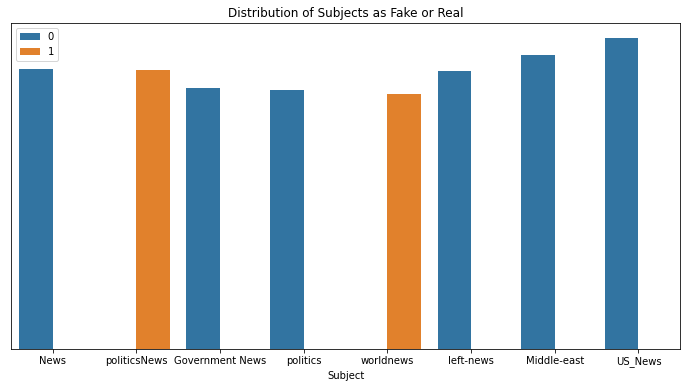

<IPython.core.display.Javascript object>

In [54]:
plt.figure(figsize=(12, 6))
sns.barplot(x="subject", y=df_subset.index, hue="real", data=df_subset, ci=None)
plt.title("Distribution of Subjects as Fake or Real")
plt.yticks([])
plt.xlabel("Subject")
plt.legend()

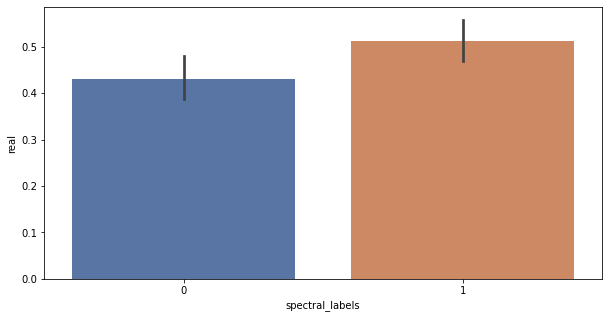

<IPython.core.display.Javascript object>

In [55]:
plt.figure(figsize=(10, 5))
sns.barplot(x="spectral_labels", y="real", palette="deep", data=df_subset)

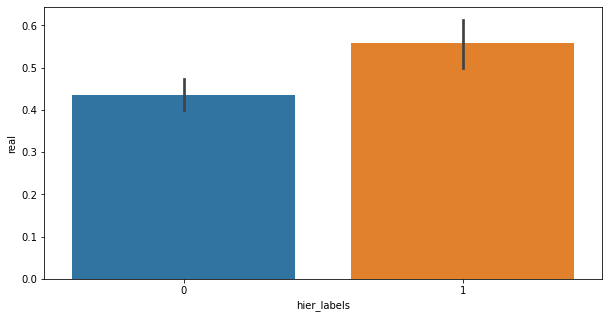

<IPython.core.display.Javascript object>

In [56]:
plt.figure(figsize=(10, 5))
sns.barplot(x="hier_labels", y="real", data=df_subset)

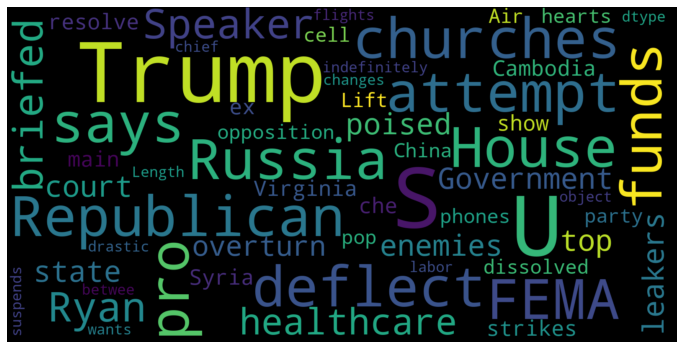

<IPython.core.display.Javascript object>

In [57]:
# Real News Worldcloud
data1 = df_subset[df_subset["real"] == 1]
neg = data1["words"]
neg_string = []
for t in neg:
    neg_string.append(t)
neg_string = pd.Series(neg_string).map(str)
neg_string = str(neg_string)


wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

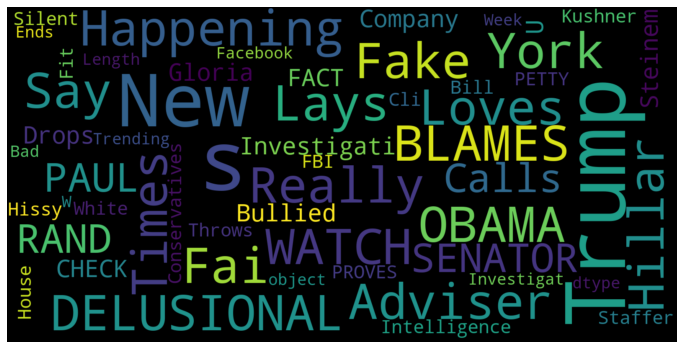

<IPython.core.display.Javascript object>

In [58]:
# Real News Worldcloud
data1 = df_subset[df_subset["real"] == 0]
neg = data1["words"]
neg_string = []
for t in neg:
    neg_string.append(t)
neg_string = pd.Series(neg_string).map(str)
neg_string = str(neg_string)


wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Misc Code: For Future Projects -- TO DO --

## Can We Utilize our K-Means labels for Semi-Supervised Classification?

Putting incorrect cell below to stop from running full analysis down below!

In [ ]:
asdf  ### Code Break ###

In [ ]:
df_subset["length"] = [len(x) for x in df_subset["words"]]
df_subset.head()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Here we preprocess the sentences
def remove_URL(s):
    regex = re.compile(r"https?://\S+|www\.\S+|bit\.ly\S+")
    return regex.sub(r"", s)


# Preprocessing functions to remove lowercase, links, whitespace, tags, numbers, punctuation, strip words
CUSTOM_FILTERS = [
    lambda x: x.lower(),
    strip_tags,
    remove_URL,
    strip_punctuation,
    strip_multiple_whitespaces,
    strip_numeric,
    remove_stopwords,
    strip_short,
]

# Here we store the processed sentences and their label
processed_data_full = []
processed_labels_full = []

for index, row in df.iterrows():
    words_broken_up = preprocess_string(row["words"], CUSTOM_FILTERS)
    # This eliminates any fields that may be blank after preprocessing
    if len(words_broken_up) > 0:
        processed_data_full.append(words_broken_up)
#         processed_labels_full.append(row["label"])

In [ ]:
X_new = []
for data_x in processed_data_full:
    X_new.append(Sentence_Vector(data_x))

In [ ]:
X_new_array = np.array(X_new)

In [ ]:
semi_sup = kmeans.fit_predict(X_new_array)

In [ ]:
new = semi_sup.labels_